In [15]:
# Time-series denoising challenge

# The goal of this notebook is to reconstruct the cleaned version of an original signal using time-series denoising techniques. The input to the notebook 
# is a .mat file containing the originalSignal and the cleanedSignal. The goal is to filter the originalSignal and obtain a clean version of it, 
# which is as close as possible to the cleanedSignal provided in the .mat file

# import libraries

import numpy as np
from matplotlib import pyplot as plt
import scipy.io as sio
import scipy.signal
from scipy import *
import copy

In [16]:
# import and plot raw and cleaned signal
# first have a look at the data

signal = sio.loadmat(r'C:\Users\GIANNI\Desktop\DSP applications on Matlab and Python\Section 2_Time Series Denoising\sigprocMXC_TimeSeriesDenoising\denoising_codeChallenge')
keys = signal.keys()
print(keys)

for i, key in enumerate (signal.keys()):
    print('Type: ', type(signal[key]))

print(signal['origSignal'].shape)  
print(signal['cleanedSignal'].shape)



dict_keys(['__header__', '__version__', '__globals__', 'cleanedSignal', 'origSignal'])
Type:  <class 'bytes'>
Type:  <class 'str'>
Type:  <class 'list'>
Type:  <class 'numpy.ndarray'>
Type:  <class 'numpy.ndarray'>
(1, 4000)
(1, 4000)


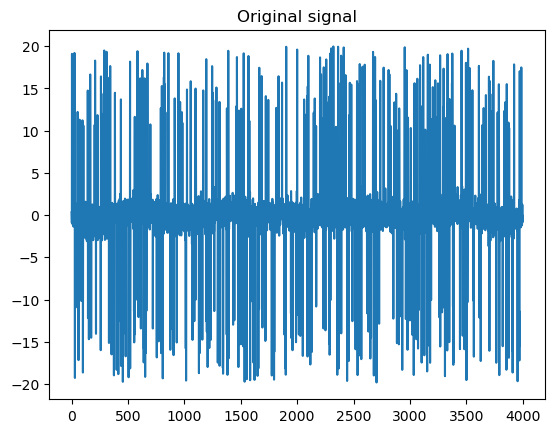

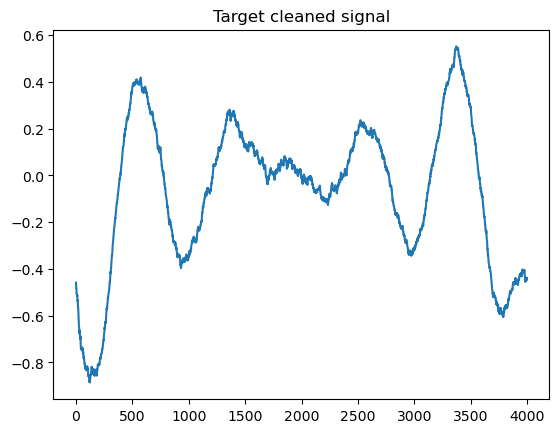

In [17]:
# save signals

origSignal = signal['origSignal'].flatten()
cleanedSignal = signal['cleanedSignal'].flatten()

# plot 

plt.figure()
plt.plot(range(len(origSignal)), origSignal, label = 'original signal')
plt.title('Original signal')
plt.show()

plt.figure()
plt.plot(range(len(cleanedSignal)), cleanedSignal, label = 'cleaned signal')
plt.title('Target cleaned signal')
plt.show()


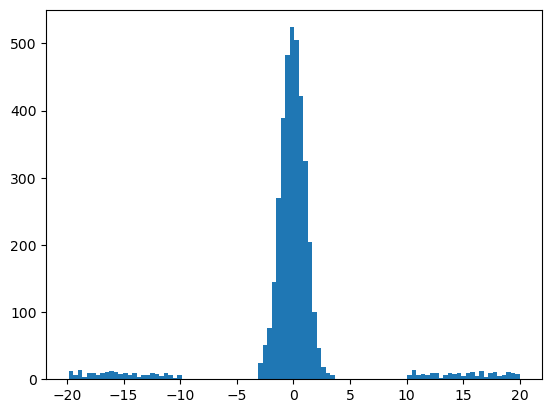

In [18]:
# Now let's start denoising, using only time-domain techniques. First of all I would plot a Gaussian to select a threshold for outliers

# use hist to pick threshold. Outliers are outside the gaussian
plt.hist(origSignal,100)
plt.show()


# from the histogram probably we can consider values outside range [-3, 3] to be outliers
# Now the next question is: how do we handle such values? ---> Let's start by applying median filter

Text(0.5, 1.0, 'Original vs median filtered signal')

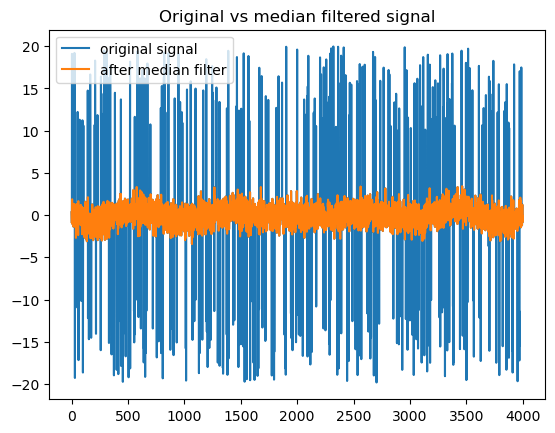

In [19]:
# MEDIAN FILTER

low_threshold = -3.5
high_threshold = 3.5
n = len(origSignal)

# find datapoints above high threshold and below low threshold
abovethreshold = np.where(origSignal > high_threshold)[0]
belowthreshold = np.where(origSignal < low_threshold)[0]

# initialize filtered signal
filtsig = copy.deepcopy(origSignal)

# loop through abovethreshold and belowthreshold points and set to median of k
k = 20 # actual window is k*2+1
for ti in range(len(abovethreshold)):

    # lower and upper bounds
    lowbnd = np.max((0,abovethreshold[ti]-k))
    uppbnd = np.min((abovethreshold[ti]+k+1,n))

    # compute median of surrounding points
    filtsig[abovethreshold[ti]] = np.median(origSignal[lowbnd:uppbnd])

for ti in range(len(belowthreshold)):

    # lower and upper bounds
    lowbnd = np.max((0,belowthreshold[ti]-k))
    uppbnd = np.min((belowthreshold[ti]+k+1,n))

    # compute median of surrounding points
    filtsig[belowthreshold[ti]] = np.median(origSignal[lowbnd:uppbnd])

# plot original signal vs median-smooth filtered signal

plt.figure()
plt.plot(range(len(origSignal)), origSignal, label = 'original signal')
plt.plot(range(len(filtsig)), filtsig, label = 'after median filter')
plt.legend()
plt.title('Original vs median filtered signal')



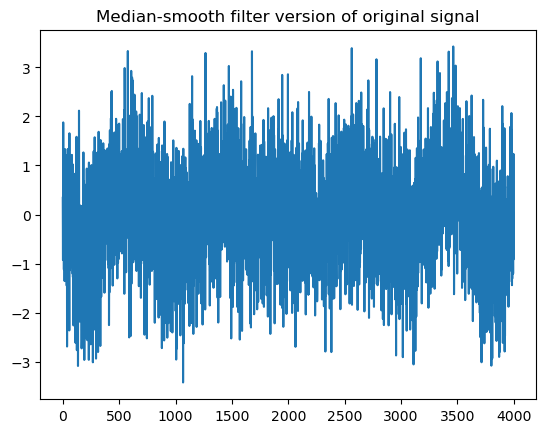

In [20]:
# Looks good! Now let's zoom it

plt.figure()
plt.plot(range(0,n), filtsig)
plt.title('Median-smooth filter version of original signal')
plt.show()


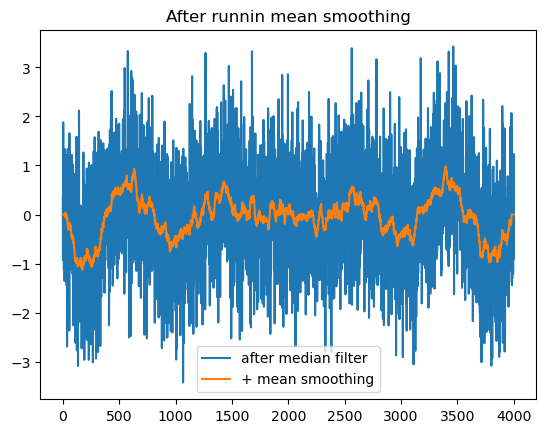

In [21]:
# now we can apply a running-mean smooth filter and see what happens

# initialization
runmean = np.zeros(len(filtsig))

# implement the running mean filter
k = 20 # filter window is actually k*2+1
for i in range(k,n-k):
    # each point is the average of k surrounding points
    runmean[i] = np.mean(filtsig[i-k:i+k+1])

plt.figure()
plt.plot(range(0,n), filtsig, label = 'after median filter')
plt.plot(range(0,n), runmean, label = '+ mean smoothing')
plt.legend()
plt.title('After runnin mean smoothing')
plt.show()

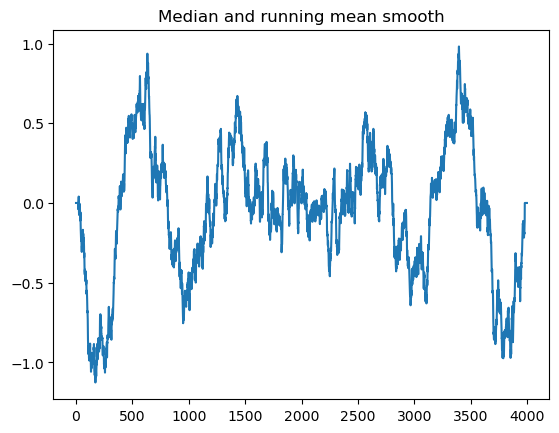

In [22]:
# let's plot it again to see if there are any additional patterns

plt.figure()
plt.plot(range(0,n), runmean)
plt.title('Median and running mean smooth')
plt.show()

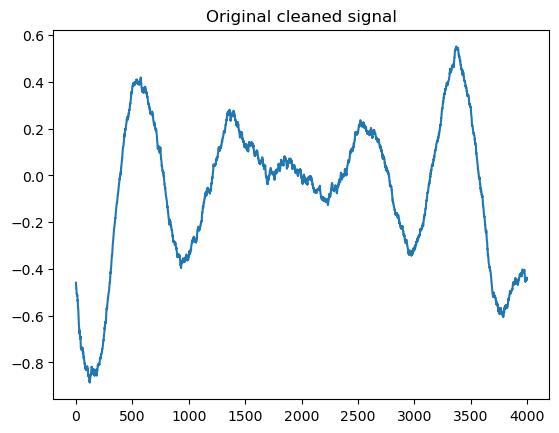

In [23]:
# Perfect! Now you can clearly see the signal is mirrored and symmetrical around 2000th timestep ish. You can potential split the signal, reverse
# the second signal and compute the average between two ripetitions. But let's have a look at the original cleaned signal before.

plt.figure()
plt.plot(range(0,n), cleanedSignal)
plt.title('Original cleaned signal')
plt.show()

# Now let's try a Gaussian smooth filter

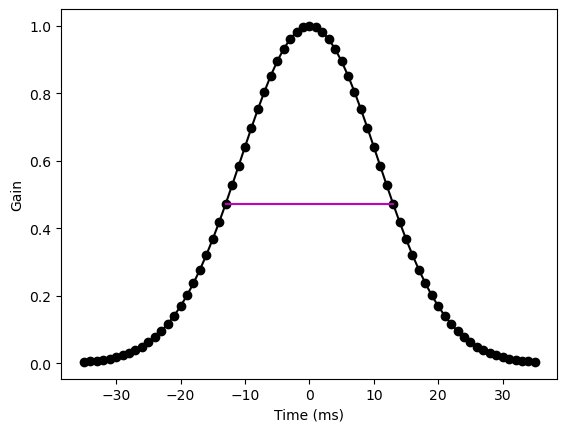

In [24]:
# Gaussian-smooth the median filtered signal

## create Gaussian kernel
# full-width half-maximum: the key Gaussian parameter
fwhm = 25 # in ms

# normalized time vector in ms
k = 35
gtime = np.arange(-k,k+1)

# create Gaussian window
gauswin = np.exp( -(4*np.log(2)*gtime**2) / fwhm**2 )

# compute empirical FWHM
pstPeakHalf = k + np.argmin( (gauswin[k:]-.5)**2 )
prePeakHalf = np.argmin( (gauswin-.5)**2 )

empFWHM = gtime[pstPeakHalf] - gtime[prePeakHalf]

# show the Gaussian
plt.plot(gtime,gauswin,'ko-')
plt.plot([gtime[prePeakHalf],gtime[pstPeakHalf]],[gauswin[prePeakHalf],gauswin[pstPeakHalf]],'m')

# then normalize Gaussian to unit energy
gauswin = gauswin / np.sum(gauswin)
# title([ 'Gaussian kernel with requeted FWHM ' num2str(fwhm) ' ms (' num2str(empFWHM) ' ms achieved)' ])
plt.xlabel('Time (ms)')
plt.ylabel('Gain')

plt.show()

Text(0.5, 1.0, 'Gaussian smoothing filter')

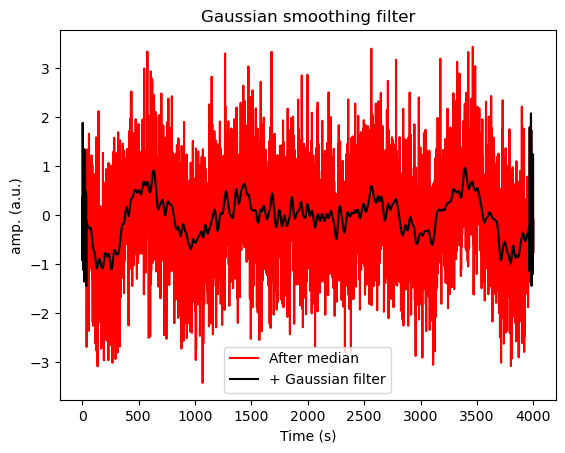

In [25]:
# now filter it

# initialize filtered signal vector
filtsigG = copy.deepcopy(filtsig)

# # implement the running mean filter
for i in range(k+1,n-k):
    # each point is the weighted average of k surrounding points
    filtsigG[i] = np.sum(filtsig[i-k:i+k+1]*gauswin )

# plot
plt.plot(range(0,n),filtsig,'r',label='After median')
plt.plot(range(0,n),filtsigG,'k',label='+ Gaussian filter')

plt.xlabel('Time (s)')
plt.ylabel('amp. (a.u.)')
plt.legend()
plt.title('Gaussian smoothing filter')

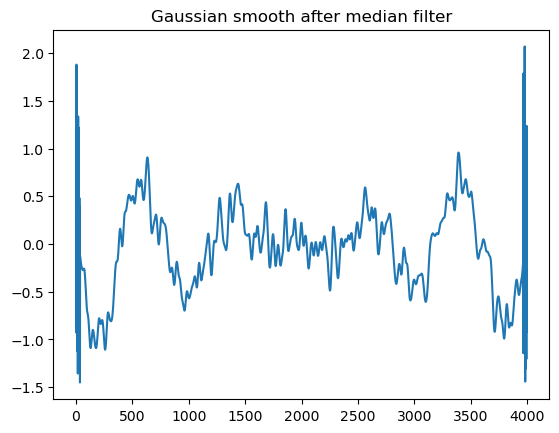

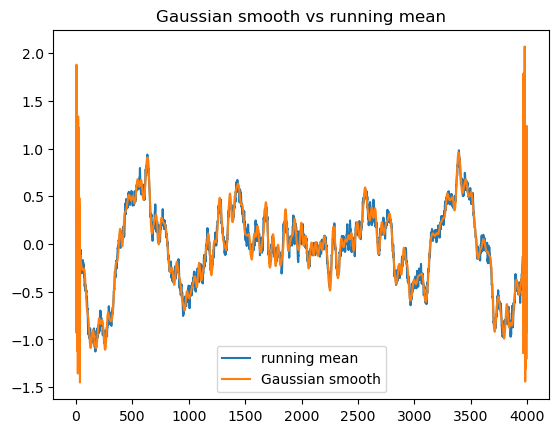

In [26]:
# now plot it alone and then together with the normal running mean smooth filter

plt.figure()
plt.plot(range(0,n), filtsigG)
plt.title('Gaussian smooth after median filter')
plt.show()

plt.figure()
plt.plot(range(0,n), runmean, label = 'running mean')
plt.plot(range(0,n), filtsigG, label = 'Gaussian smooth')
plt.legend()
plt.title('Gaussian smooth vs running mean')
plt.show()

In [ ]:
# Signals look similar but the Gaussian-smooth version comes with extra edge effect